# Transfer learning with TensorFlow Part 1: Feature Exatraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.


## Downloading and becoming one with the data

In [1]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()


--2023-05-18 18:49:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  20.2MB/s    in 9.4s    

2023-05-18 18:49:29 (17.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

## Creating data loaders (preparing the data)

We'll use the ImageDataGenerator class to load in our images in batches.

In [3]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [4]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback

### Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our models layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [5]:
# let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [6]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns:
    An uncompiled keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras Layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,  # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMG_SHAPE+(3,))
  # Create our won model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [8]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [9]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [10]:
# Let's fit our resNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving Tensorboard log files to: tensorflow_hub/resnet50V2/20230518-185046
Epoch 1/5
24/24 [==============================] - 36s 904ms/step - loss: 1.8928 - accuracy: 0.3747 - val_loss: 1.2407 - val_accuracy: 0.5952
Epoch 2/5
24/24 [==============================] - 19s 797ms/step - loss: 0.9315 - accuracy: 0.7120 - val_loss: 0.8480 - val_accuracy: 0.7348
Epoch 3/5
24/24 [==============================] - 20s 843ms/step - loss: 0.6316 - accuracy: 0.8147 - val_loss: 0.7743 - val_accuracy: 0.7452
Epoch 4/5
24/24 [==============================] - 18s 780ms/step - loss: 0.4882 - accuracy: 0.8693 - val_loss: 0.7190 - val_accuracy: 0.7636
Epoch 5/5
24/24 [==============================] - 20s 858ms/step - loss: 0.3935 - accuracy: 0.9040 - val_loss: 0.7019 - val_accuracy: 0.7776


Wow!! That is truly incredible. Out tranfer learning feature extractor model out performed ALL of the previous models we build by hand... (substantially) and in a quicker training time and with only 10 % of the training examples.

In [11]:
# Let's create a function to plot our loss curves...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics.
  
  Args:
    history: TensorFlow History object.

  Returns:
    Plots of taining/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

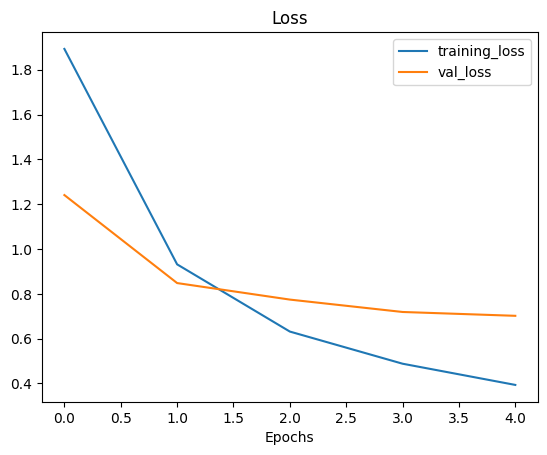

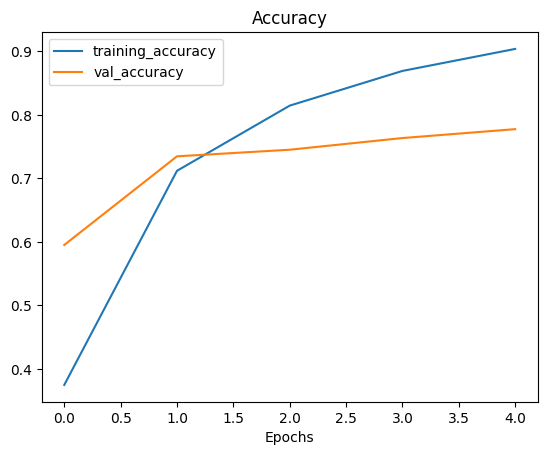

In [12]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [13]:
# Create the EfficientNetB0 model
efficientnet_model = create_model(model_url = efficientnet_url,
                                  num_classes= train_data_10_percent.num_classes) 

In [14]:
# Compile our efficientnet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [15]:
# Fit our EfficientNetB0 model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="EfficientNetB0")])

Saving Tensorboard log files to: tensorflow_hub/EfficientNetB0/20230518-185409
Epoch 1/5
24/24 [==============================] - 31s 881ms/step - loss: 1.8874 - accuracy: 0.4133 - val_loss: 1.2930 - val_accuracy: 0.7484
Epoch 2/5
24/24 [==============================] - 18s 763ms/step - loss: 1.0701 - accuracy: 0.7680 - val_loss: 0.8518 - val_accuracy: 0.8268
Epoch 3/5
24/24 [==============================] - 19s 833ms/step - loss: 0.7548 - accuracy: 0.8387 - val_loss: 0.6850 - val_accuracy: 0.8508
Epoch 4/5
24/24 [==============================] - 17s 741ms/step - loss: 0.6078 - accuracy: 0.8693 - val_loss: 0.5998 - val_accuracy: 0.8588
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.5156 - accuracy: 0.8907 - val_loss: 0.5475 - val_accuracy: 0.8652


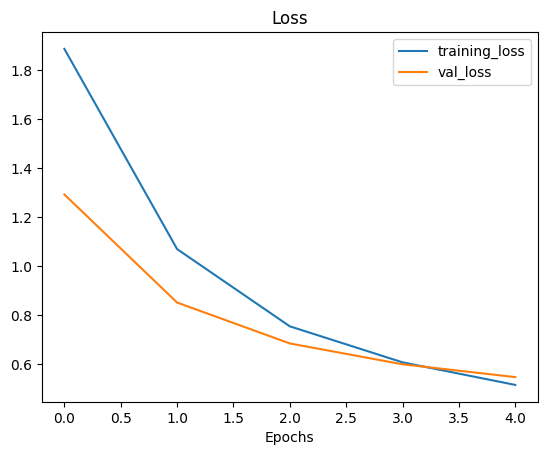

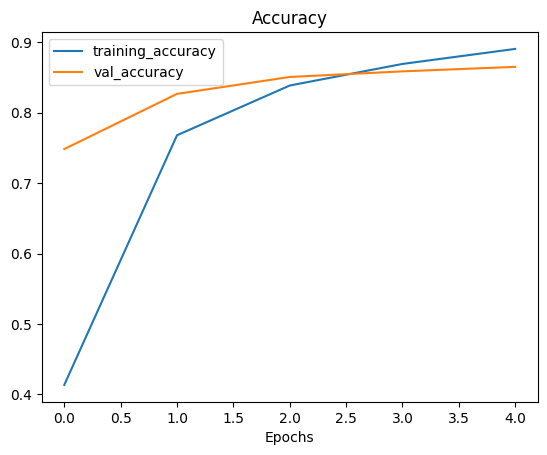

In [17]:
# Let's visualize the loss curves of our EfficientNet model
plot_loss_curves(efficientnet_history)

In [26]:
efficientnet_model.summary();

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [16]:
resnet_model.summary();

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Different types of transfer learning

* **"As is"** transfer learning - using an existing model with no changes what so ever (e.g. using ImageNet model on 1000 ImageNet classes, no of your own)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning"** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers. (including new output layers)

## Comparing our models results using TensorBoard

**Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetB0 vs. ResNet50V2"\
--description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data"
--one_shot

2023-05-18 19:24:09.662267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/nQH1OzTZTr6D7LxMHnrPhQ/

[2023-05-18T19:24:12] Started scanning logdir.
[2023-05-18T19:24:17] Total uploaded: 60 scalars, 0 tensors, 2 binary objects (5.7 MB)


In [22]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2023-05-18 19:23:40.396614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/gMSmP0gFRuGyJyPwd1dSQg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   gMSmP0gFRuGyJyPwd1dSQg
	Created              2023-05-18 19:20:34 (3 minutes ago)
	Updated              2023-05-18 19:20:39 (3 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5934984
Total: 1 experiment(s)
